In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/HW3/lfw.zip" -d "/content/drive/MyDrive/HW3/"
path = '/content/drive/MyDrive/HW3/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


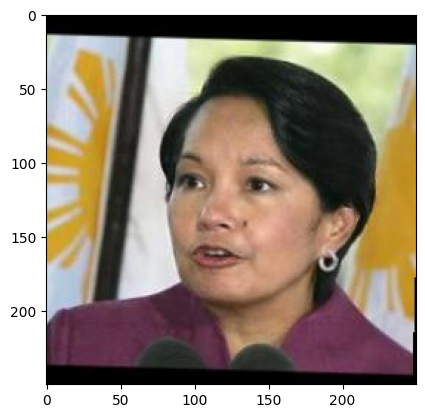

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [7]:
batch = next(iter(dataloader))
batch_size, _, _, _ = batch[0].shape

print(f"Dimensions: {batch[0].shape}")


Dimensions: torch.Size([32, 3, 250, 250])


Dimension of the Image is : (250, 250, 3)

The first parameter is the height of the Image(number of pixels in the height). The Second parameter is the width of the Image(number of pixels in the width). The third parameter is number of channels in the image( RGB ).


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        return nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

    def build_decoder(self):
        return nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
            nn.Upsample(size=(250, 250), mode='bilinear')  # Upsample to the desired size
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [9]:

# Create an instance of the AE model
autoencoder = AE()

# Move the model to the device
autoencoder.to(device)

# Print the shapes of encoder and decoder outputs
with torch.no_grad():
    input_image = torch.randn(32, 3, 250, 250).to(device) # Example image with desired dimensions
    encoded_output = autoencoder.encoder(input_image)
    decoded_output = autoencoder.decoder(encoded_output)

print("Shape of the encoded output:", encoded_output.shape)
print("Shape of the decoded output:", decoded_output.shape)

Shape of the encoded output: torch.Size([32, 64, 32, 32])
Shape of the decoded output: torch.Size([32, 3, 250, 250])


Encoder Output Shape: torch.Size([32, 64, 32, 32])

The output shape indicates that it has 32 samples in the batch. Each sample is represented by 64 channels. The spatial dimensions are reduced to 32x32, suggesting that the encoder has downsized the input image.

Decoder Output Shape: torch.Size([32, 3, 250, 250])

The output shape indicates 32 samples in the batch. The decoder has reconstructed the image with 3 channels (RGB) as expected. The spatial dimensions are increased to 250x250, matching the input image dimensions. By using upsampling the input image size, decoded image size are matched.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [10]:
# Print total number of parameters in the model
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total number of parameters: {total_params}")

# Explain the loss function you should use
# For an autoencoder, a common choice is Mean Squared Error (MSE) loss
loss_function = nn.MSELoss()

# Create an optimizer for training
# Example: Adam optimizer with a learning rate of 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)


Total number of parameters: 47427


For the loss function,

since this is an image reconstruction task, Mean Squared Error (MSE) loss is commonly used. It measures the average squared difference between the predicted and target values. In PyTorch, you can use torch.nn.MSELoss()

For the optimizer,

we choice is Adam. Here's an example of using the Adam optimizer: This initializes the Adam optimizer with a learning rate of 0.001. You can adjust the learning rate based on your specific task and data.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
num_epochs = 12  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training loop
    for data in dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = autoencoder(inputs)

        # Compute the loss
        loss = loss_function(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}")


Epoch [1/12], Loss: 0.0035692264307920197
Epoch [2/12], Loss: 0.003525831990825813
Epoch [3/12], Loss: 0.003378027404438038
Epoch [4/12], Loss: 0.0033358586220979545
Epoch [5/12], Loss: 0.0033074305173468547
Epoch [6/12], Loss: 0.003132877582324228
Epoch [7/12], Loss: 0.003085136201552111
Epoch [8/12], Loss: 0.0030690935257021426
Epoch [9/12], Loss: 0.003023959705853556
Epoch [10/12], Loss: 0.0030978388532069356
Epoch [11/12], Loss: 0.0030187679013768255
Epoch [12/12], Loss: 0.0029596613825789253


TroubleShooting:

There is not much of the decrease in the learning rate for the epochs. Decrease Learning Rate: If the loss is not decreasing, try decreasing the learning rate. A smaller learning rate might help the optimizer converge more slowly but with more stability. 1-> I have tried with the learning rate(1e-3). There was no decrease in the Loss. 2-> I have changed the learning rate by decreasing it to 1e-5.Now, I see the decrease in the loss for the epochs. Dropout: Add dropout layers to your model to prevent overfitting. Weight Decay: Introduce weight decay in the optimizer to penalize large weights.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

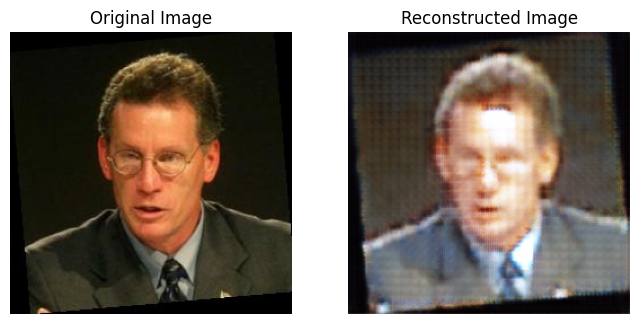

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a random image from the dataset
random_index = np.random.randint(len(dataloader.dataset))
sample_image, _ = dataloader.dataset[random_index]
sample_image = sample_image.unsqueeze(0)

# Encode and decode the image using the trained autoencoder
with torch.no_grad():
    reconstructed_image = autoencoder(sample_image)

# Convert tensors to numpy arrays for visualization
sample_image_np = sample_image.cpu().numpy().squeeze().transpose((1, 2, 0))
reconstructed_image_np = reconstructed_image.cpu().numpy().squeeze().transpose((1, 2, 0))

# Plot the original and reconstructed images side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

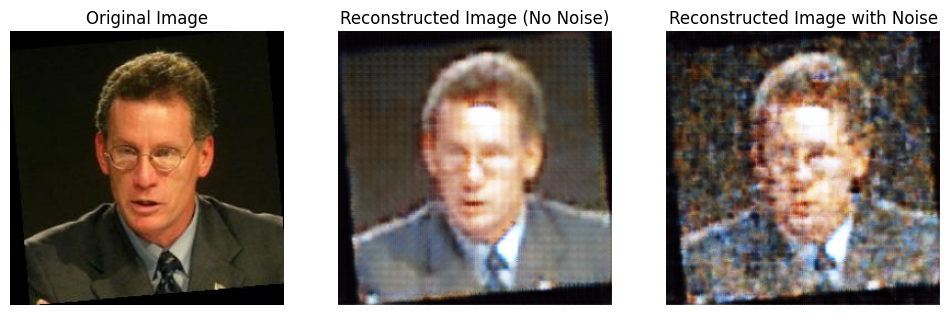

In [ ]:


# Encode the image
with torch.no_grad():
    encoded_image = autoencoder.encoder(sample_image)

# Add small normal distributed noise to the encoded image
noise = torch.randn_like(encoded_image) * 1
noisy_encoded_image = encoded_image + noise

# Decode the noisy encoded image
with torch.no_grad():
    reconstructed_image_with_noise = autoencoder.decoder(noisy_encoded_image)

# Convert tensors to numpy arrays for visualization
sample_image_np = sample_image.cpu().numpy().squeeze().transpose((1, 2, 0))
reconstructed_image_np_noise = reconstructed_image_with_noise.cpu().numpy().squeeze().transpose((1, 2, 0))

# Plot the original and reconstructed images side by side
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(sample_image_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Reconstructed Image (No Noise)')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Reconstructed Image with Noise')
plt.imshow(reconstructed_image_with_noise.cpu().numpy().squeeze().transpose((1, 2, 0)))
plt.axis('off')

plt.show()


Effect of noise on decoded Image :

We start with a clean image, and then add some form of noise to it. This noise could follow a specific pattern.

The noisy image serves as the input to the denoising autoencoder. Adding noise to the latent representation of the input image and then decoding it can help investigate the robustness of the denoising autoencoder to additional noise in the latent space.

Now, you can observe how adding noise to the latent representation affects the decoded output. Adding a small amount of noise to the latent representation can impact the image.

The noise in the latent space may create slight variations in the decoded output. The extent of this impact depends on the amount of noise added and the architecture of the autoencoder.

Experimenting with different noise levels will lead to changes in decoded output.